# Soft Computing

## Lab 1: Multilayer Perceptron

In [16]:
from IPython.display import HTML, display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

%matplotlib inline

In [2]:
plt.style.use('bmh')

## Eksplorasi Dataset

Dataset yang akan kita gunakan *MNIST handwritten digit dataset* atau MNIST. MNIST adalah salah satu dataset paling populer untuk permulaan untuk mengujicobakan berbagai metode pengenalan pola yang tidak perlu melalui banyak prapemrosesan. Deskripsi lengkap dataset ini dapat dilihat di [sini](http://yann.lecun.com/exdb/mnist/).

In [3]:
# Memuat data
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

Dimensi dari data yang dihasilkan adalah:

In [4]:
X_train.shape

(60000, 28, 28)

Artinya, ada 60000 data/gambar, berukuran 28x28 pixels. Sekarang, kita akan coba mengambil 5 sampel dari data latih, lalu menggambarnya.

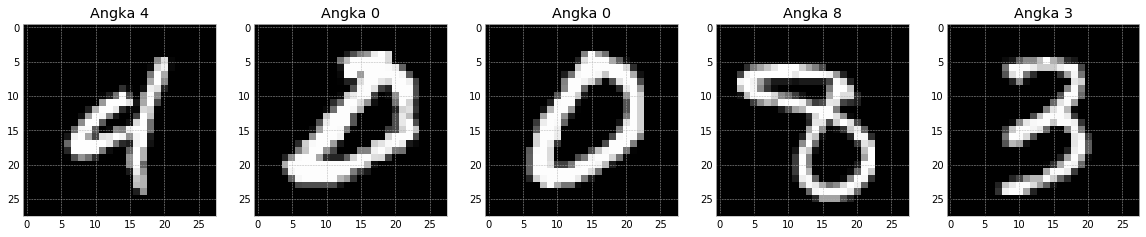

In [5]:
np.random.seed(42)

fig, axes = plt.subplots(figsize=(20,4), ncols=5)
ix = np.random.randint(X_train.shape[0], size=5)
for im, y, ax in zip(X_train[ix], Y_train[ix], axes.flatten()):
    ax.set_title('Angka {}'.format(y))
    ax.imshow(im, cmap='gist_gray')
plt.show()

Jika kita lihat lebih detail, gambar tersebut sebetulnya terdiri dari sejumlah pixel yang bernilai 0-255, seperti gambar digital pada umumnya. Agar lebih yakin, kita dapat menggambarnya dengan cara berikut.

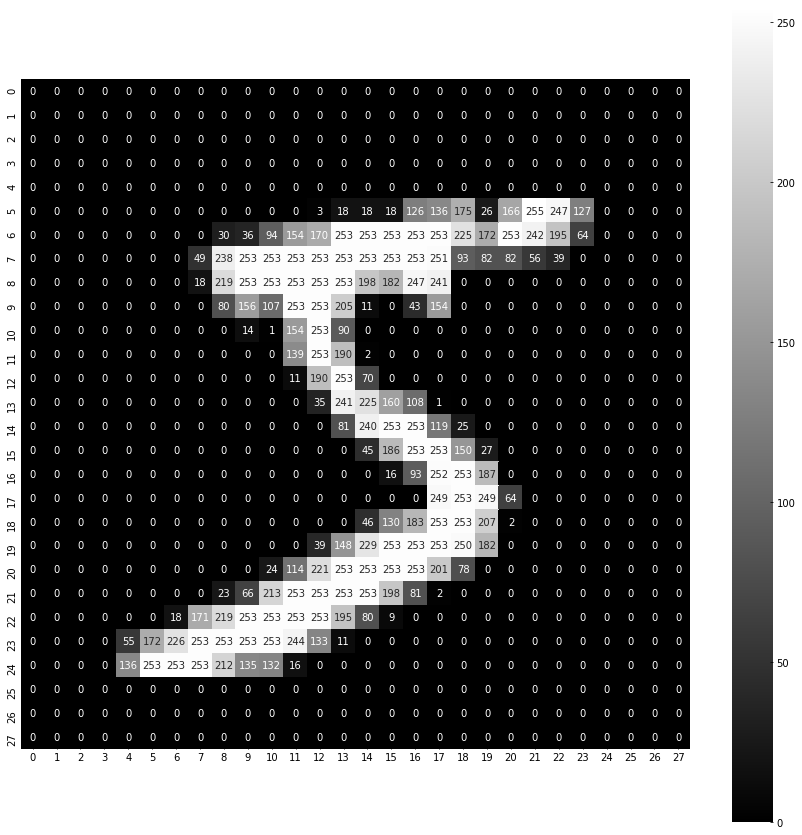

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(
    X_train[0], # mengambil data pertama (indeks ke-0) saja
    annot=True, # anotasi heatmap-nya, i.e. tuliskan angka di tiap kotak
    fmt='d', # angka ditulis dalam bentuk integer
    cmap='gist_gray', # ganti warnanya menjadi abu-abu
    square=True, # bentuk gambarnya agar menjadi persegi
    ax=ax
);

## Membuat Model Neural Network

Sekarang, kita akan mencoba mendefinisikan sebuah model neural network. Model ini akan terdiri dari dua hidden layers dan menggunakan fungsi aktivasi softmax di output layer.

In [7]:
def net1(num_classes):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(512, activation='sigmoid', input_shape=(784,)))
    model.add(tf.keras.layers.Dense(256, activation='sigmoid'))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))
    return model

Dari model yang sudah kita definisikan tersebut, jumlah parameter yang dapat dilatih dan arsitektur akhirnya dapat dilihat dengan cara sebagai berikut.

In [8]:
num_classes = 10

model = net1(num_classes)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


Perhatikan layer terakhirnya! Jika kita menggunakan 256 hidden units di hidden layer terakhir dan ada 10 units di output layer, maka seharusnya ada 256x10=2560 weights. Mengapa yang tertulis adalah 2570?

### Preprocessing

Sebelum datanya bisa dimuat untuk melatih model neural network, ada beberapa prapemrosesan yang harus dilakukan, antara lain mengubah dimensinya menjadi $N\times784$. Nilai $784$ ini didapat dari $28\times28$ pixels sebuah gambar.

Selain itu, untuk mempercepat proses pelatihan, biasanya nilai dari input data dibuat kecil dengan normalisasi. Dalam kasus ini, nilainya dibagi dengan 255 agar $x \in [0,1]$.

Bagian akhir dari kode di bawah ini adalah penerapan *one-hot* atau *one-of-k encoder* pada label/kelas yang akan digunakan.

In [9]:
x_train = X_train.reshape(60000, 784)
x_test = X_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

y_train = tf.keras.utils.to_categorical(Y_train, num_classes)
y_test = tf.keras.utils.to_categorical(Y_test, num_classes)

Untuk memastikan perubahannya, mari kita lihat pada 5 data pertama.

In [10]:
Y_train[:5]

array([5, 0, 4, 1, 9], dtype=uint8)

In [11]:
pd.DataFrame(y_train[:5], columns=range(10))

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Perhatikan bahwa nilai yang bernilai 1 dari setiap baris hanya ada 1. Nilai ini berhubungan dengan kelas dari gambar tersebut.

### Melatih Model

Setelah datanya sudah disiapkan, kita dapat melatih model dengan terlebih dahulu mendefinisikan beberapa parameter tambahan.

In [12]:
np.random.seed(42)

batch_size = 128
num_classes = 10
epochs = 20

model = net1(num_classes)
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01), # Stochastic Gradient Descent dengan lr (learning rate) = η
    metrics=['accuracy']
)

Dalam kasus ini, kita menggunakan fungsi error *categorical cross-entropy* yang didefinisikan sebagai
$$
E(\mathbf{w}) = - \sum_{k=1}^K y_k \log \hat{y}_k
$$
Di samping fungsi error, kita juga mendefinisikan metrik yang akan menjadi tujuan kita. Metrik ini yang biasanya digunakan untuk membandingkan kinerja satu model dengan model lainnya. Saat ini, kita menggunakan metrik berupa *akurasi*.

Setelah mendefinisikan fungsi error, metode optimasi, dan metrik, kita dapat melatih modelnya.

In [13]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1, # mencetak proses pelatihan
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss: {:.4f}'.format(score[0]))
print('Test accuracy: {:.2%}'.format(score[1]))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 3s 58us/step - loss: 2.2625 - acc: 0.2409 - val_loss: 2.2155 - val_acc: 0.3659
Epoch 2/20
60000/60000 [==============================] - 3s 52us/step - loss: 2.1696 - acc: 0.4435 - val_loss: 2.1141 - val_acc: 0.4823
Epoch 3/20
60000/60000 [==============================] - 3s 55us/step - loss: 2.0488 - acc: 0.5589 - val_loss: 1.9650 - val_acc: 0.6001
Epoch 4/20
60000/60000 [==============================] - 3s 54us/step - loss: 1.8761 - acc: 0.6251 - val_loss: 1.7608 - val_acc: 0.6665
Epoch 5/20
60000/60000 [==============================] - 3s 55us/step - loss: 1.6525 - acc: 0.6769 - val_loss: 1.5166 - val_acc: 0.7290
Epoch 6/20
60000/60000 [==============================] - 3s 48us/step - loss: 1.4119 - acc: 0.7232 - val_loss: 1.2799 - val_acc: 0.7381
Epoch 7/20
60000/60000 [==============================] - 3s 56us/step - loss: 1.1960 - acc: 0.7571 - val_loss: 1.0861 - val_acc

In [28]:
display(HTML(
    'Model yang dihasilkan mendapatkan akurasi {:.2%} pada data latih dan {:.2%} pada data uji.'.format(
        history.history['acc'][-1], history.history['val_acc'][-1]
    )
))

Untuk melihat lebih jelas perubahan nilainya (proses pembelajarannya), kita dapat menggambarkan *learning curve*-nya sebagai berikut.

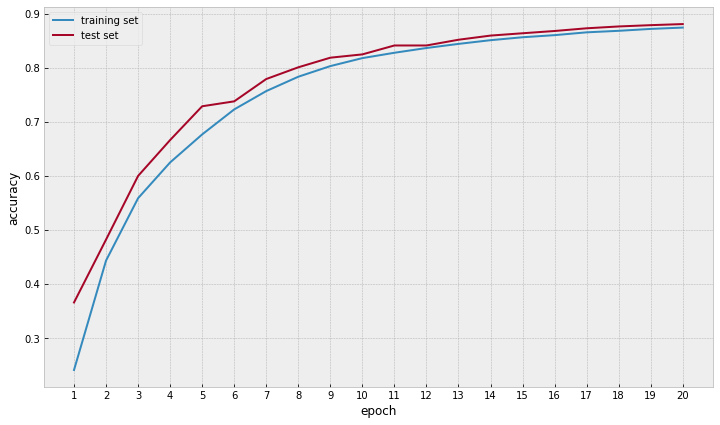

In [14]:
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(range(1,21), history.history['acc'], label='training set')
plt.plot(range(1,21), history.history['val_acc'], label='test set')
plt.xticks(range(1,21), range(1,21))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend();

Selain *learning curve* dari akurasinya, kita juga dapat menggambarkan *learning curve* dari fungsi errornya.

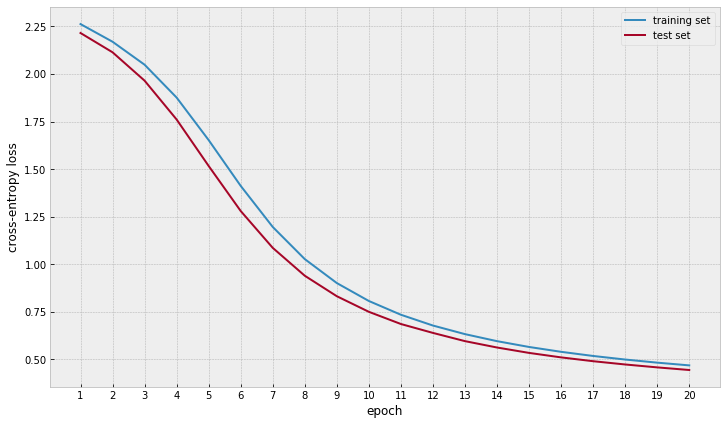

In [15]:
fig, ax = plt.subplots(figsize=(12,7))
plt.plot(range(1,21), history.history['loss'], label='training set')
plt.plot(range(1,21), history.history['val_loss'], label='test set')
plt.xticks(range(1,21), range(1,21))
plt.xlabel('epoch')
plt.ylabel('cross-entropy loss')
plt.legend();

Perhatikan bahwa ada kemungkinan untuk memperbaiki model dengan epoch yang lebih banyak karena akurasinya terlihat masih bisa naik beberapa titik lagi. Apakah Anda bisa melakukannya?